In [ ]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [1]:
#@title Load coordinates nearest points

import time
import plotly.express as px
import pandas as pd
from scipy.stats import shapiro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMRegressor
import pickle
from sklearn.pipeline import Pipeline

coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/distan_lat43.302lon-8.377p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Shapiro test normality

p value: 0.015769656747579575
Accept null hypothesis: normal distribution variable

Observed wind intensity statistics


count    89579.000000
mean        14.087868
std          5.153830
min         -3.150000
25%         10.850000
50%         13.850000
75%         17.850000
max         35.850000
Name: temp_o, dtype: float64

,MAE,MSE,R2,MedianAE
Point 0,1.51,3.80,0.86,1.21
Point 1,1.40,3.24,0.88,1.13
Point 2,1.43,3.41,0.87,1.16
Point 3,1.41,3.34,0.88,1.13


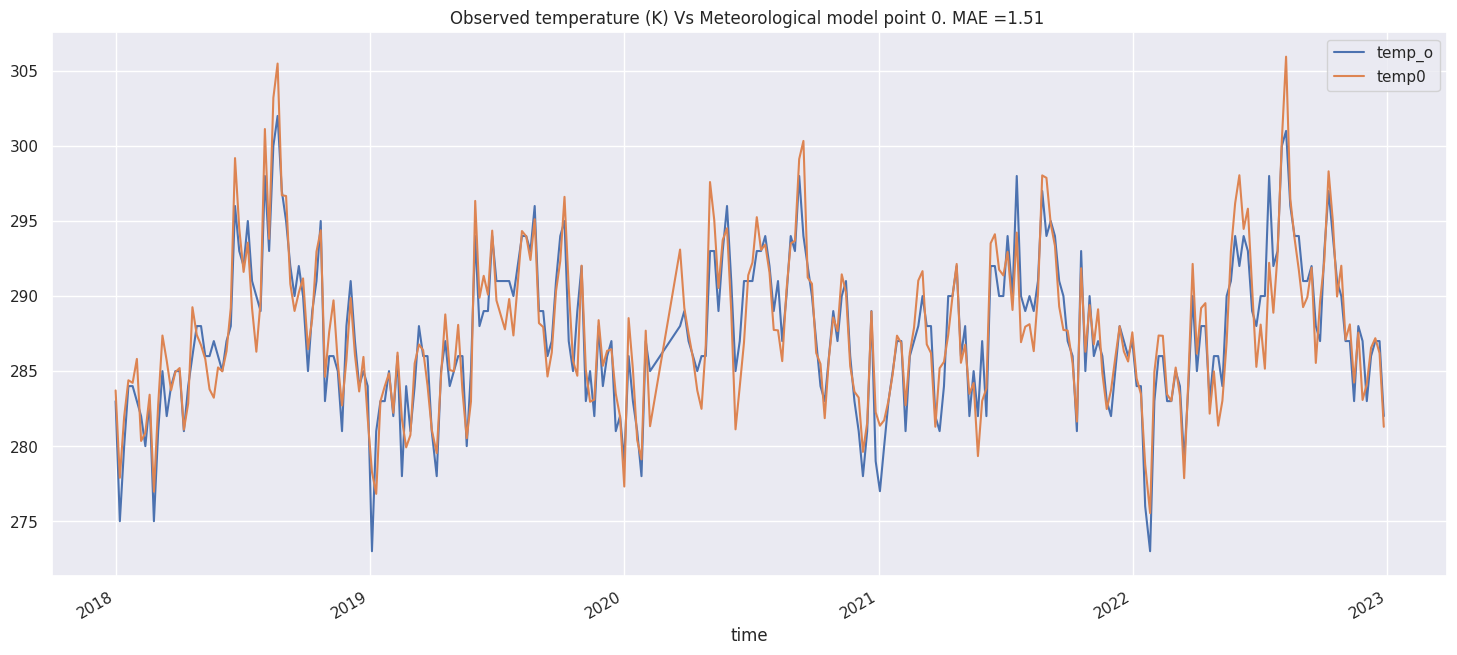

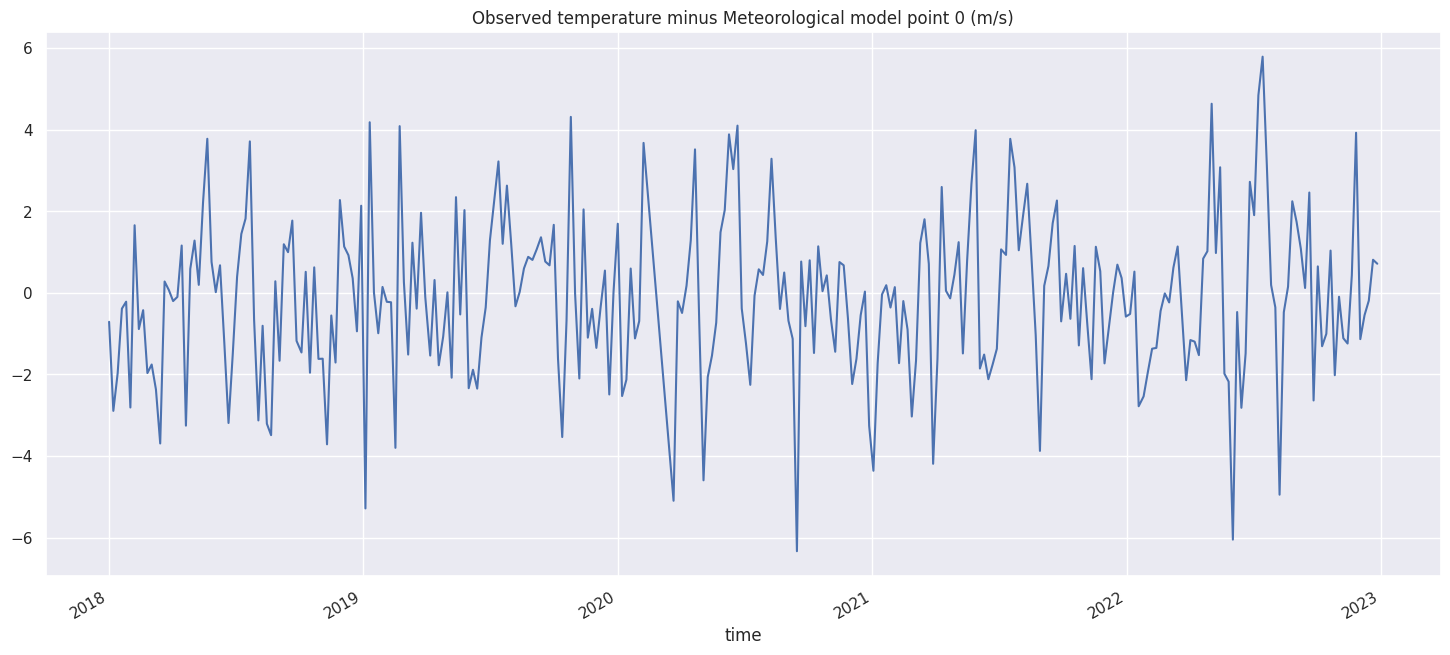

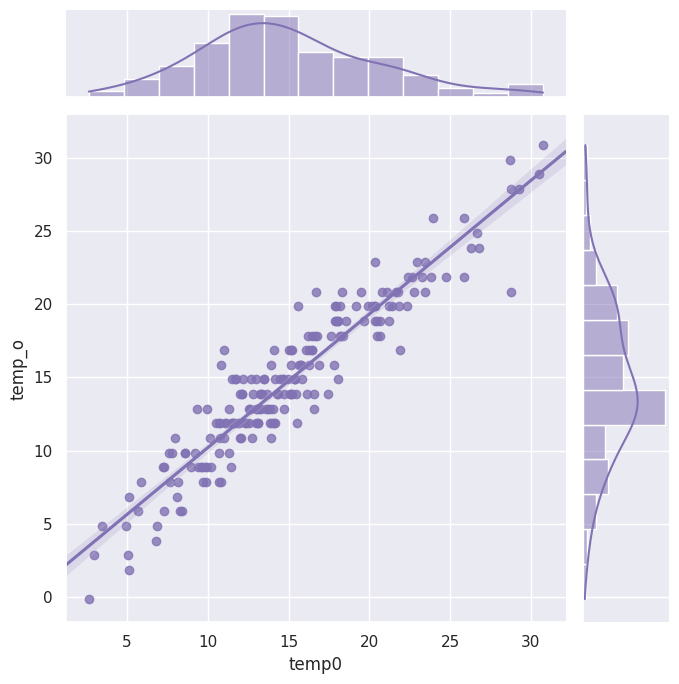

In [21]:
#@title Load station and meteorological model (Forecast D0). Concatenate station and meteorological model. Meteorological model score

station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/LECOY2018Y2022.csv",
                          usecols = ["time","temp_o"],
                          parse_dates=["time"]).set_index("time")

#Shapiro test normality
print("Shapiro test normality")
sta, p = shapiro(station.temp_o.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  

print("Observed wind intensity statistics")
display((round(station["temp_o"]-273.15,2)).describe())

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2022.csv",parse_dates=["time"])
model1k = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station model
df_all = pd.concat([station,model1k],axis=1).dropna()


#metmodel score point 0
#Mean absolute error
MAE0 = round(mean_absolute_error(df_all["temp_o"], df_all["temp0"]),2)
#MSE 
MSE0 = round(mean_squared_error(df_all["temp_o"], df_all["temp0"]),2)
#R2
R20 = round(r2_score(df_all["temp_o"], df_all["temp0"]),2)
#Median absolute error
MedianAE0 = round(median_absolute_error(df_all["temp_o"], df_all["temp0"]),2)

#metmodel score point 1
#Mean absolute error
MAE1 = round(mean_absolute_error(df_all["temp_o"], df_all["temp1"]),2)
#MSE 
MSE1 = round(mean_squared_error(df_all["temp_o"], df_all["temp1"]),2)
#R2
R21 = round(r2_score(df_all["temp_o"], df_all["temp1"]),2)
#Median absolute error
MedianAE1 = round(median_absolute_error(df_all["temp_o"], df_all["temp1"]),2)

#metmodel score point 2
#Mean absolute error
MAE2 = round(mean_absolute_error(df_all["temp_o"], df_all["temp2"]),2)
#MSE 
MSE2 = round(mean_squared_error(df_all["temp_o"], df_all["temp2"]),2)
#R2
R22 = round(r2_score(df_all["temp_o"], df_all["temp2"]),2)
#Median absolute error
MedianAE2 = round(median_absolute_error(df_all["temp_o"], df_all["temp2"]),2)

#metmodel score point 3
#Mean absolute error
MAE3 = round(mean_absolute_error(df_all["temp_o"], df_all["temp3"]),2)
#MSE 
MSE3 = round(mean_squared_error(df_all["temp_o"], df_all["temp3"]),2)
#R2
R23 = round(r2_score(df_all["temp_o"], df_all["temp3"]),2)
#Median absolute error
MedianAE3 = round(median_absolute_error(df_all["temp_o"], df_all["temp3"]),2)




df_r =pd.DataFrame({"Point 0":[MAE0,MSE0,R20,MedianAE0],
                    "Point 1":[MAE1,MSE1,R21,MedianAE1],
                    "Point 2":[MAE2,MSE2,R22,MedianAE2],
                    "Point 3":[MAE3,MSE3,R23,MedianAE3]},index = ["MAE","MSE","R2","MedianAE"])

display(df_r.T)

#observed versus met model
fig, ax = plt.subplots(figsize=(18,8))
df_all[["temp_o","temp0"]][0::140].plot(ax=ax,grid =True,);
title = "Observed temperature (K) Vs Meteorological model point 0. MAE ={} ".format(MAE0)
ax.set_title(title)
ax.grid(True, which = "both", axis = "both")
plt.show(fig)

#observed versus met model
fig, ax = plt.subplots(figsize=(18,8))
(df_all["temp_o"]-df_all["temp0"])[0::140].plot(ax=ax,grid =True,);
ax.set_title("Observed temperature minus Meteorological model point 0 (m/s)")
ax.grid(True, which = "both", axis = "both")
plt.show(fig)

#observed versus met model

sns.set_theme(style="darkgrid")
sns.jointplot(x="temp0", y="temp_o", data=(df_all[["temp_o","temp0"]]-273.15).sample(200),
                  kind="reg", truncate=False,
                  color="m", height=7,);


Machine learning results


,MAE,MSE,R2,Median_AE
0,0.89,1.36,0.95,0.70
1,0.88,1.30,0.95,0.71
2,0.89,1.36,0.95,0.71
3,0.90,1.42,0.95,0.71
4,0.87,1.32,0.95,0.69
5,0.89,1.36,0.95,0.71
6,0.88,1.35,0.95,0.69
7,0.91,1.43,0.95,0.71
8,0.90,1.39,0.95,0.71
9,0.88,1.32,0.95,0.69


Comparing differences machine learning meteorological model


,dif_met,dif_ml
count,6126.000000,6126.000000
mean,0.072605,-0.004827
std,1.947636,1.147212
min,-8.505890,-6.324791
25%,-1.135529,-0.713826
50%,0.075745,-0.036531
75%,1.252991,0.672756
max,10.661621,5.928966


Shapiro test normality differences meteorologic model

p value: 1.88004214578541e-05
Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable

Shapiro test normality differences machine learning model

p value: 0.00848962552845478
Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable

Execution time: 0.79 minutes


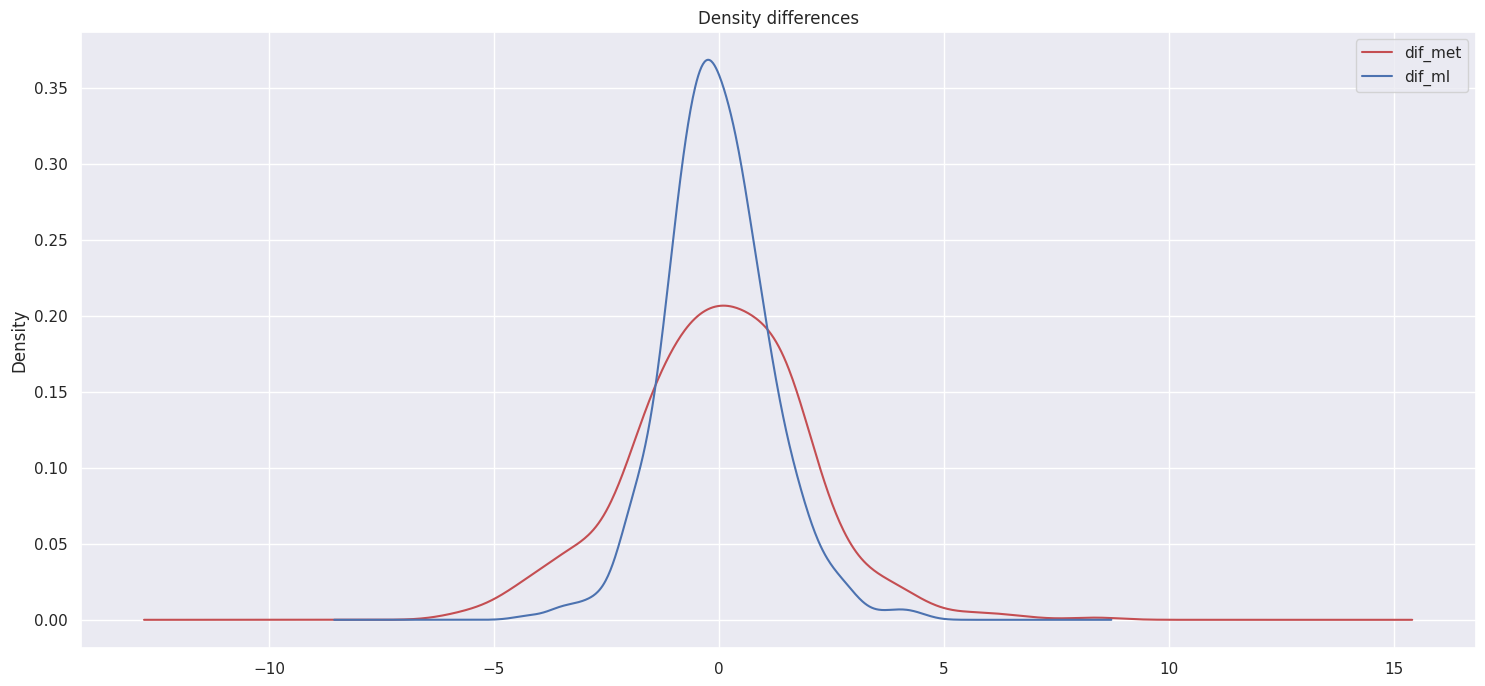

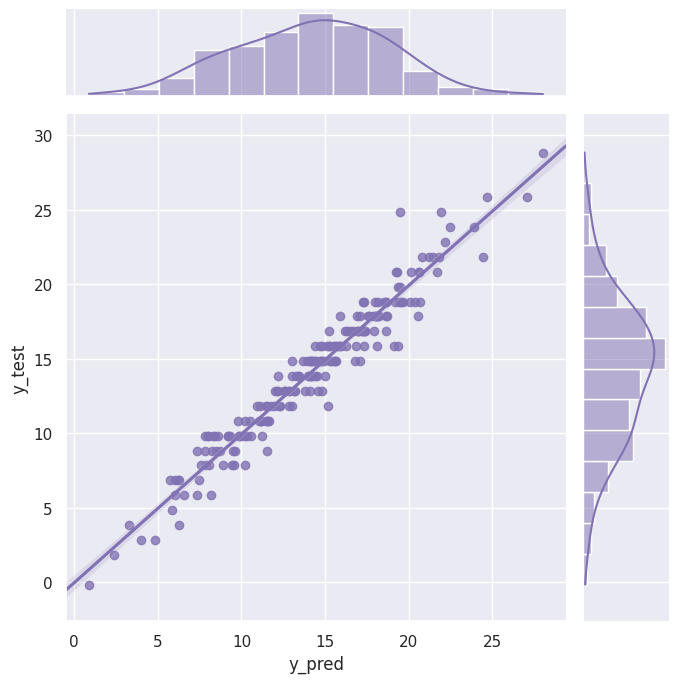

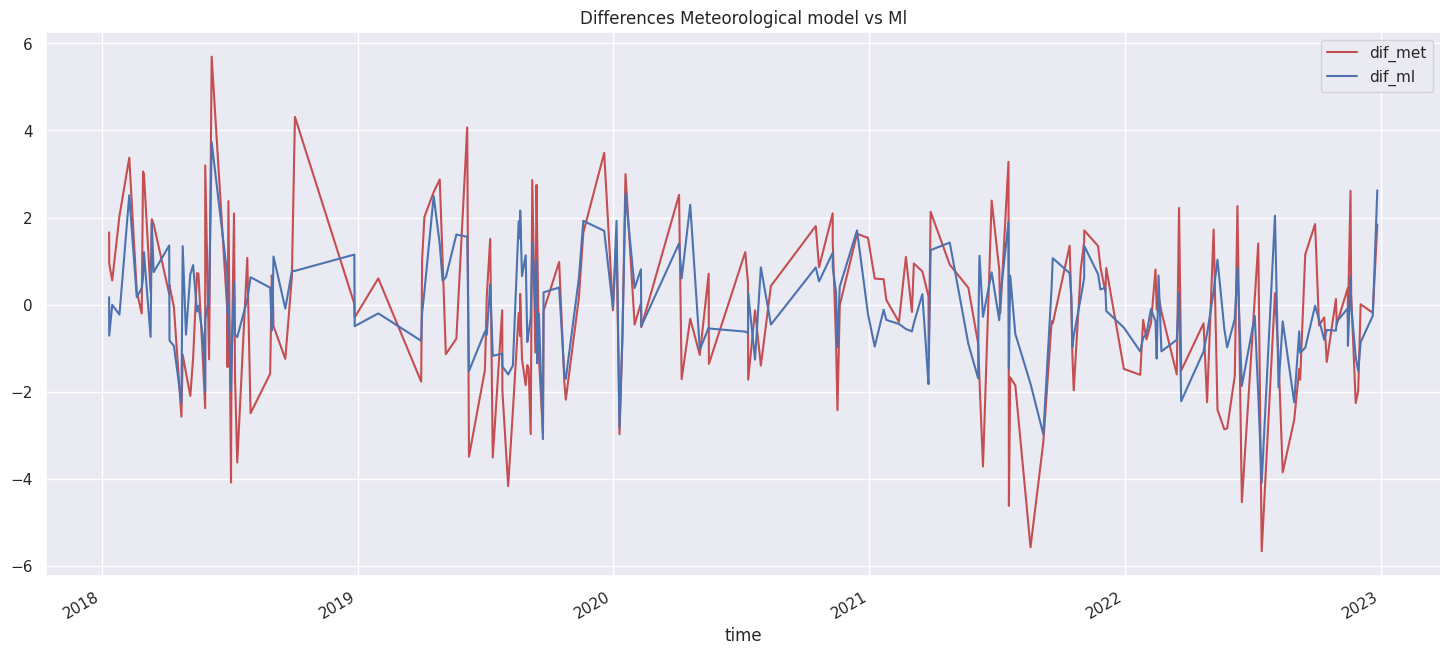

In [22]:
#@title Add time variables. Machine learning algorithm score. Save algorithm

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)
df_all.iloc[:,1:].columns

#random seed 1
np.random.seed(1)

# X and Y
Y = df_all.temp_o
X = df_all.iloc[:,1:]

# loop random
Median_AE_ml = []
Mean_AE_ml =[]
MSE_ml = []
R2_ml = []

#20 samples to test algorithm
#random seed 1
np.random.seed(1)
print("Machine learning results")
for t in range (0,10):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.15, )

  #machine learning model
  ml_model = LGBMRegressor().fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  
  #Score calculation
  Mean_AE_ml.append(round(mean_absolute_error(y_test, y_pred),2))
  Median_AE_ml.append(round(median_absolute_error(y_test, y_pred),2))
  MSE_ml.append (round(mean_squared_error(y_test, y_pred),2))
  R2_ml.append(round(r2_score(y_test, y_pred),2))

display(pd.DataFrame({"MAE":Mean_AE_ml,"MSE":MSE_ml,"R2":R2_ml,"Median_AE":Median_AE_ml}))  

#show results sample 200
result = pd.DataFrame({"y_pred":y_pred,"y_test":y_test.values,"temp0":X_test.temp0.values}).set_index(y_test.index)

result["dif_met"]=result['temp0']-result['y_test']
result["dif_ml"]=result['y_pred']-result['y_test']
print("Comparing differences machine learning meteorological model")
display(result[["dif_met","dif_ml"]].describe())

result[["dif_met","dif_ml"]].sample(500).plot(figsize=(18, 8),grid =True,color=["r","b"],kind="kde",title="Density differences");

sns.set_theme(style="darkgrid")
g = sns.jointplot(x="y_pred", y="y_test", data=(result[["y_pred","y_test"]]-273.15).sample(200),
                  kind="reg", truncate=False,
                  color="m", height=7)

result[["dif_met","dif_ml"]].sample(200).plot(figsize=(18, 8),grid =True,color=["r","b"], title="Differences Meteorological model vs Ml");

#Shapiro test normality meteorologic model
print("Shapiro test normality differences meteorologic model")
sta, p = shapiro(result.dif_met.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  

#Shapiro test normality machine learning model
print("Shapiro test normality differences machine learning model")
sta, p = shapiro(result.dif_ml.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  


#download algorithm
x_var = X.columns
score = {"MAE_met":MAE0,"MAE_ml":Mean_AE_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/temp_LECO_d0.al", 'wb'))

#time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", round(execution_time/60,2), "minutes")

,MAE,MSE,R2,MedianAE
Point 0,1.55,4.04,0.85,1.25
Point 1,1.43,3.38,0.87,1.17
Point 2,1.46,3.58,0.87,1.17
Point 3,1.44,3.48,0.87,1.16


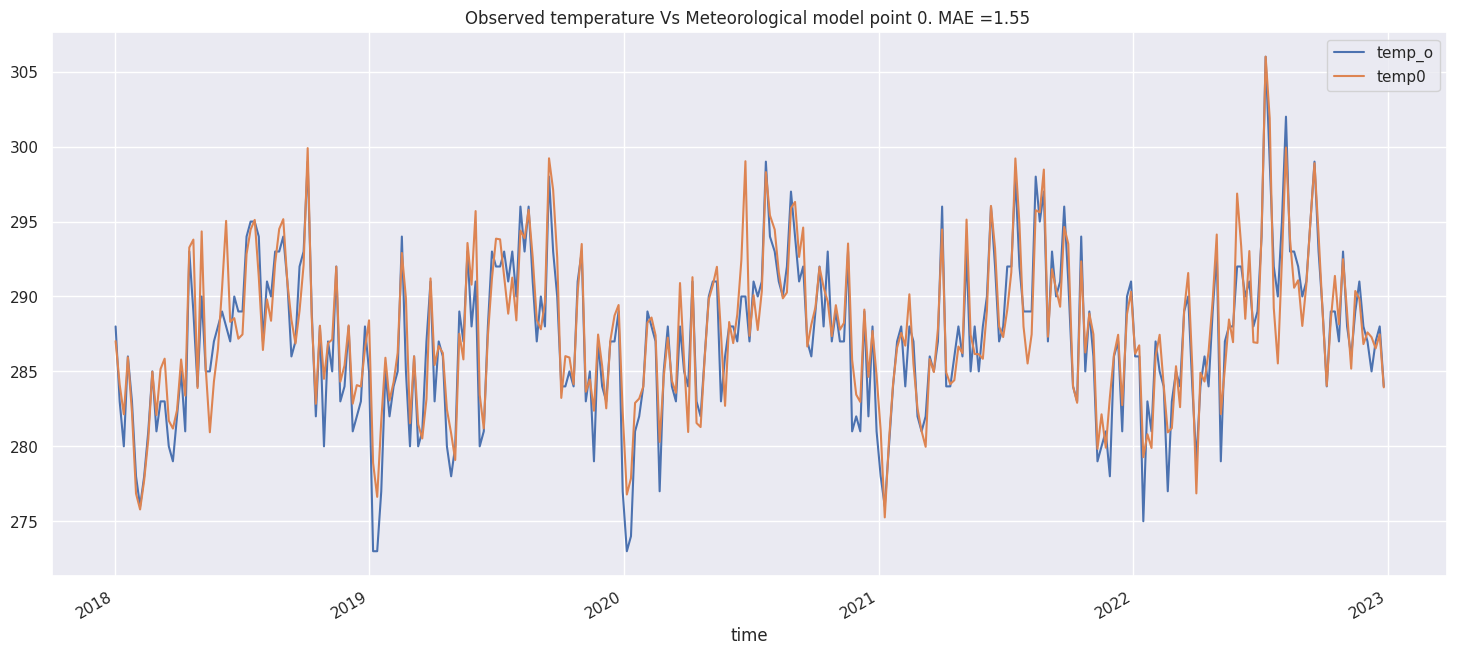

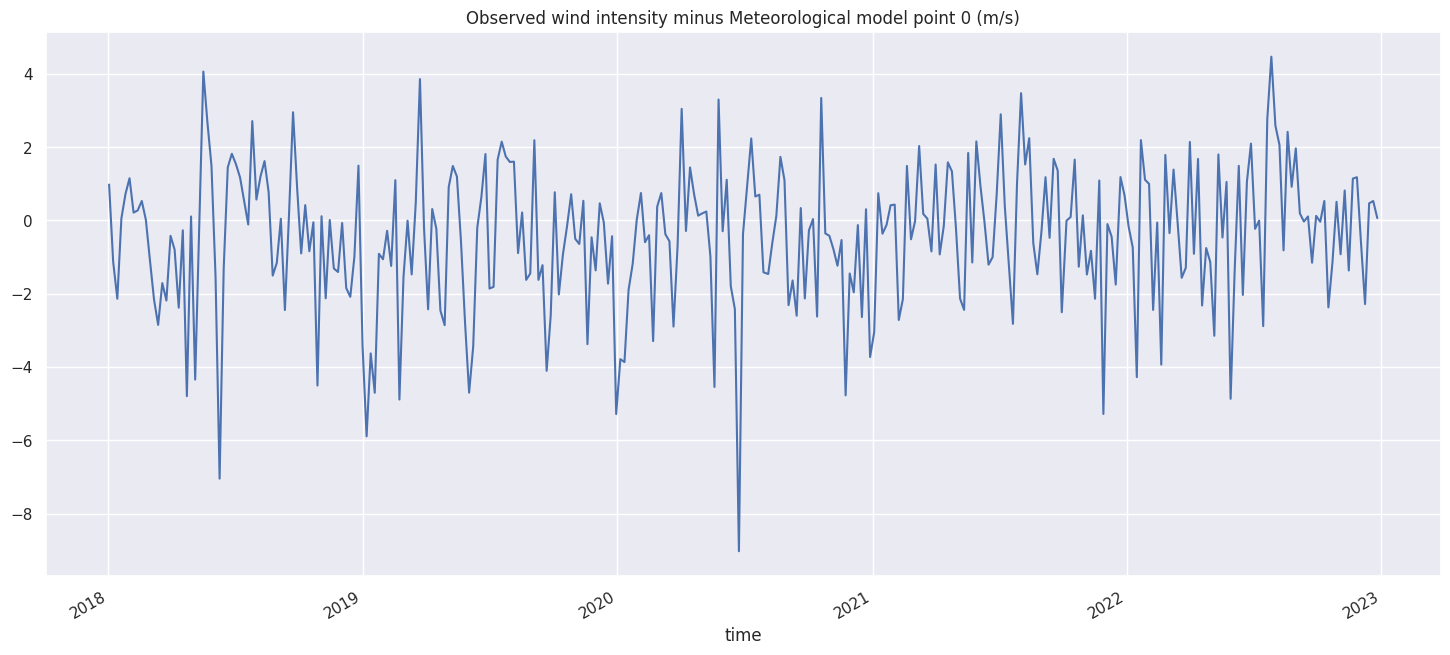

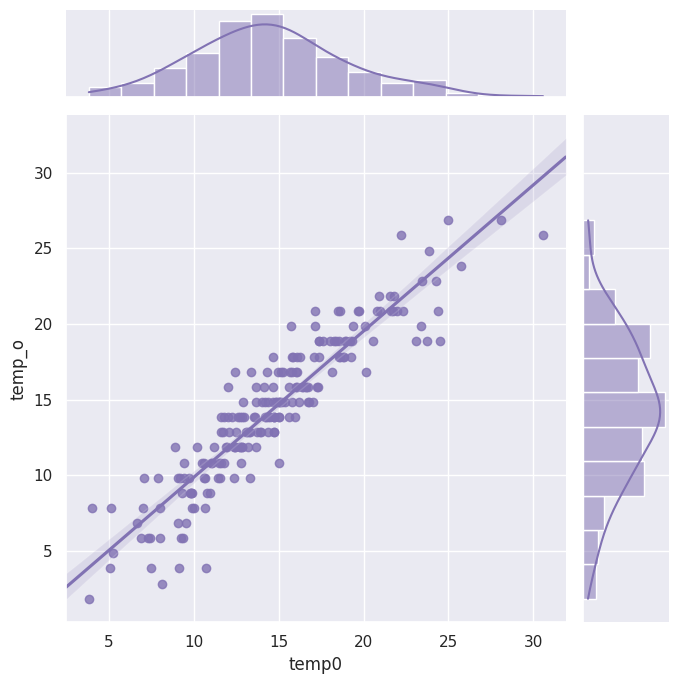

In [26]:
#@title Concatenate station and meteorological model (Forecast D1). Meteorological model score

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2022.csv",parse_dates=["time"])
model1k = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station model
df_all = pd.concat([station,model1k],axis=1).dropna()

#metmodel score point 0
#Mean absolute error
MAE0 = round(mean_absolute_error(df_all["temp_o"], df_all["temp0"]),2)
#MSE 
MSE0 = round(mean_squared_error(df_all["temp_o"], df_all["temp0"]),2)
#R2
R20 = round(r2_score(df_all["temp_o"], df_all["temp0"]),2)
#Median absolute error
MedianAE0 = round(median_absolute_error(df_all["temp_o"], df_all["temp0"]),2)

#metmodel score point 1
#Mean absolute error
MAE1 = round(mean_absolute_error(df_all["temp_o"], df_all["temp1"]),2)
#MSE 
MSE1 = round(mean_squared_error(df_all["temp_o"], df_all["temp1"]),2)
#R2
R21 = round(r2_score(df_all["temp_o"], df_all["temp1"]),2)
#Median absolute error
MedianAE1 = round(median_absolute_error(df_all["temp_o"], df_all["temp1"]),2)

#metmodel score point 2
#Mean absolute error
MAE2 = round(mean_absolute_error(df_all["temp_o"], df_all["temp2"]),2)
#MSE 
MSE2 = round(mean_squared_error(df_all["temp_o"], df_all["temp2"]),2)
#R2
R22 = round(r2_score(df_all["temp_o"], df_all["temp2"]),2)
#Median absolute error
MedianAE2 = round(median_absolute_error(df_all["temp_o"], df_all["temp2"]),2)

#metmodel score point 3
#Mean absolute error
MAE3 = round(mean_absolute_error(df_all["temp_o"], df_all["temp3"]),2)
#MSE 
MSE3 = round(mean_squared_error(df_all["temp_o"], df_all["temp3"]),2)
#R2
R23 = round(r2_score(df_all["temp_o"], df_all["temp3"]),2)
#Median absolute error
MedianAE3 = round(median_absolute_error(df_all["temp_o"], df_all["temp3"]),2)

df_r =pd.DataFrame({"Point 0":[MAE0,MSE0,R20,MedianAE0],
                    "Point 1":[MAE1,MSE1,R21,MedianAE1],
                    "Point 2":[MAE2,MSE2,R22,MedianAE2],
                    "Point 3":[MAE3,MSE3,R23,MedianAE3]},index = ["MAE","MSE","R2","MedianAE"])

display(df_r.T)

#observed versus met model
fig, ax = plt.subplots(figsize=(18,8))
df_all[["temp_o","temp0"]][0::140].plot(ax=ax,grid =True,);
title = "Observed temperature Vs Meteorological model point 0. MAE ={} ".format(MAE0)
ax.set_title(title)
ax.grid(True, which = "both", axis = "both")
plt.show(fig)

#observed versus met model
fig, ax = plt.subplots(figsize=(18,8))
(df_all["temp_o"]-df_all["temp0"])[0::140].plot(ax=ax,grid =True,);
ax.set_title("Observed wind intensity minus Meteorological model point 0 (m/s)")
ax.grid(True, which = "both", axis = "both")
plt.show(fig)

#observed versus met model

sns.set_theme(style="darkgrid")
sns.jointplot(x="temp0", y="temp_o", data=(df_all[["temp_o","temp0"]]-273.15).sample(200),
                  kind="reg", truncate=False,
                  color="m", height=7,);


Machine learning results


,MAE,MSE,R2,Median_AE
0,0.96,1.60,0.94,0.77
1,0.95,1.56,0.94,0.75
2,0.94,1.55,0.94,0.75
3,0.96,1.58,0.94,0.76
4,0.95,1.55,0.94,0.76
5,0.96,1.61,0.94,0.76
6,0.97,1.61,0.94,0.77
7,0.96,1.61,0.94,0.76
8,0.96,1.59,0.94,0.76
9,0.96,1.60,0.94,0.77


Comparing differences machine learning meteorological model


,dif_met,dif_ml
count,6528.000000,6528.000000
mean,0.270552,-0.018376
std,1.971820,1.266547
min,-8.762054,-5.708421
25%,-1.037071,-0.807398
50%,0.228088,-0.058745
75%,1.433846,0.723135
max,10.148376,6.664860


Shapiro test normality differences meteorologic model

p value: 9.758069791132584e-05
Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable

Shapiro test normality differences machine learning model

p value: 0.1440349668264389
Accept null hypothesis: normal distribution variable

Execution time: 0.73 minutes


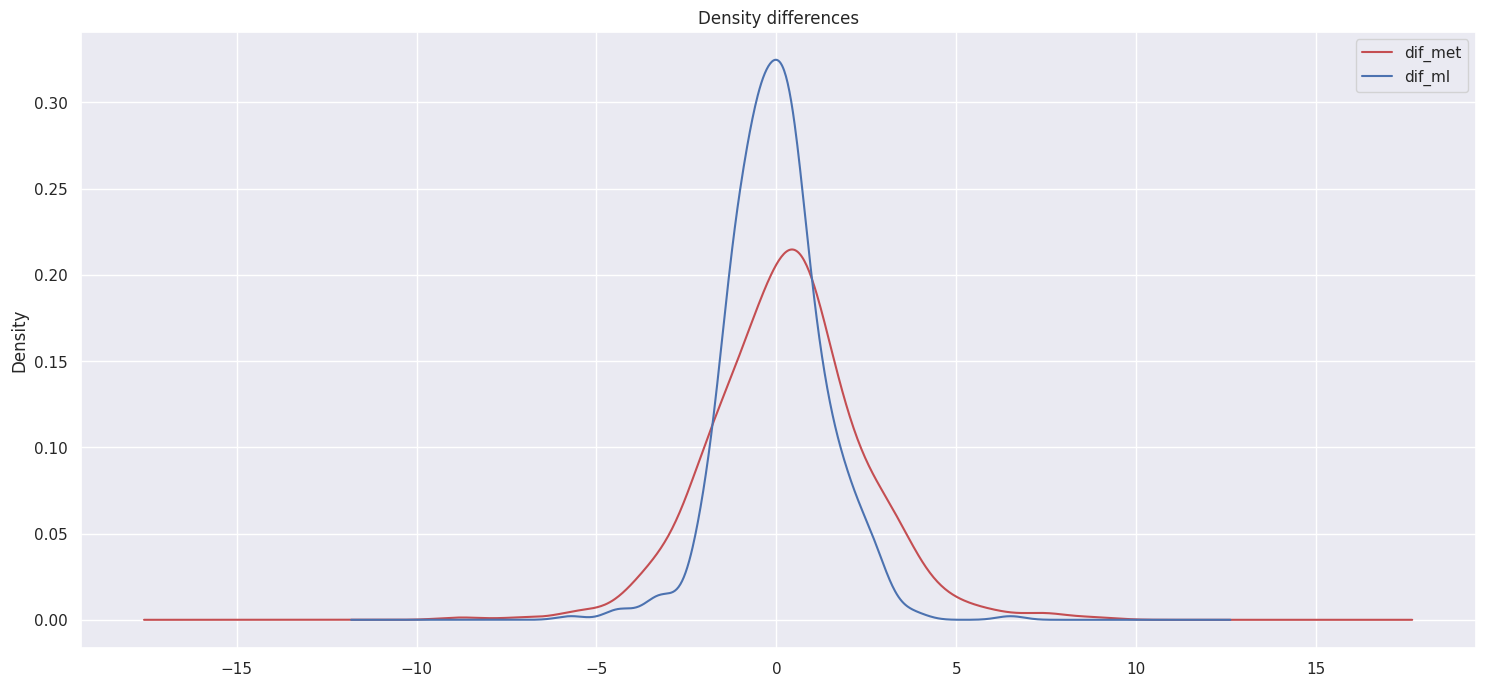

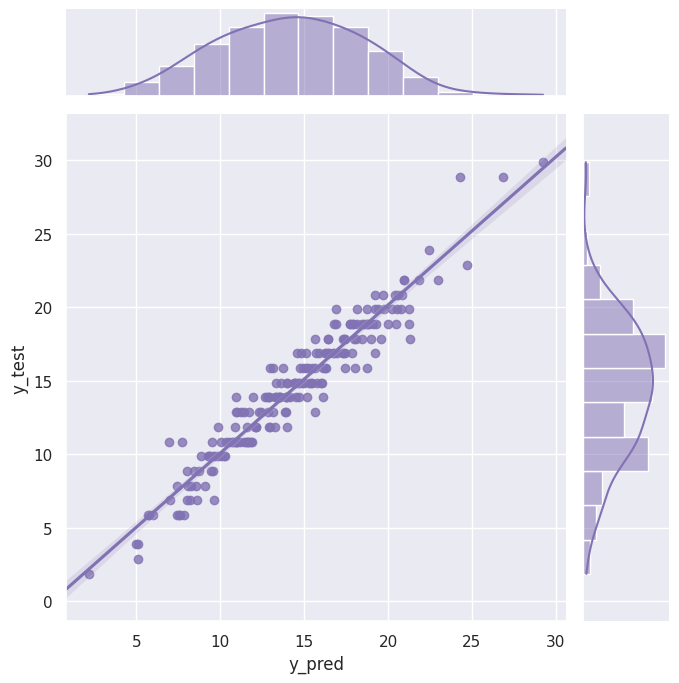

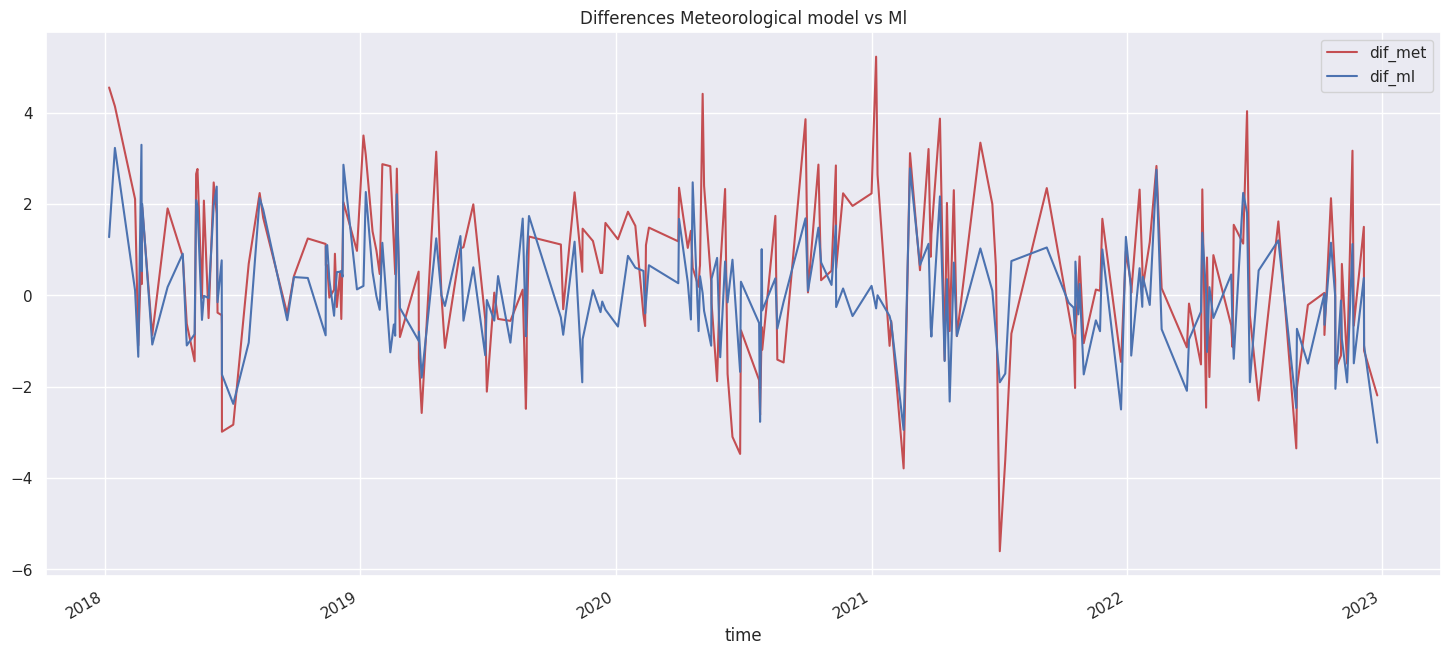

In [28]:
#@title Add time variables. Machine learning algorithm score. Save algorithm

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)
df_all.iloc[:,1:].columns

#random seed 1
np.random.seed(1)

# X and Y
Y = df_all.temp_o
X = df_all.iloc[:,1:]

# loop random
Median_AE_ml = []
Mean_AE_ml =[]
MSE_ml = []
R2_ml = []

#20 samples to test algorithm
#random seed 1
np.random.seed(1)
print("Machine learning results")
for t in range (0,10):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.15, )

  #machine learning model
  ml_model = LGBMRegressor().fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  
  #Score calculation
  Mean_AE_ml.append(round(mean_absolute_error(y_test, y_pred),2))
  Median_AE_ml.append(round(median_absolute_error(y_test, y_pred),2))
  MSE_ml.append (round(mean_squared_error(y_test, y_pred),2))
  R2_ml.append(round(r2_score(y_test, y_pred),2))

display(pd.DataFrame({"MAE":Mean_AE_ml,"MSE":MSE_ml,"R2":R2_ml,"Median_AE":Median_AE_ml}))  

#show results sample 200
result = pd.DataFrame({"y_pred":y_pred,"y_test":y_test.values,"temp0":X_test.temp0.values}).set_index(y_test.index)

result["dif_met"]=result['temp0']-result['y_test']
result["dif_ml"]=result['y_pred']-result['y_test']
print("Comparing differences machine learning meteorological model")
display(result[["dif_met","dif_ml"]].describe())

result[["dif_met","dif_ml"]].sample(500).plot(figsize=(18, 8),grid =True,color=["r","b"],kind="kde",title="Density differences");

sns.set_theme(style="darkgrid")
g = sns.jointplot(x="y_pred", y="y_test", data=(result[["y_pred","y_test"]]-273.15).sample(200),
                  kind="reg", truncate=False,
                  color="m", height=7)

result[["dif_met","dif_ml"]].sample(200).plot(figsize=(18, 8),grid =True,color=["r","b"], title="Differences Meteorological model vs Ml");

#Shapiro test normality meteorologic model
print("Shapiro test normality differences meteorologic model")
sta, p = shapiro(result.dif_met.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  

#Shapiro test normality machine learning model
print("Shapiro test normality differences machine learning model")
sta, p = shapiro(result.dif_ml.sample(500))

print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable\n")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable no normal distribution variable\n")  


#download algorithm
x_var = X.columns
score = {"MAE_met":MAE0,"MAE_ml":Mean_AE_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/temp_LECO_d1.al", 'wb'))

#time
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", round(execution_time/60,2), "minutes")